<a href="https://colab.research.google.com/github/TYH71/AIML_CA2/blob/main/Modified_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import relevant libraries/classes/dependencies
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import datetime
!pip install -q pytz
import pytz
sg = pytz.timezone("Singapore")

# Set the random seeds - to ensure reproducibility
os.environ['TF_CUDNN_DETERMINISTIC'] = "1"
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# Matplotlib Stylings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.autolayout'] = True
plt.style.use('fivethirtyeight')

In [3]:
# install and configure weights and biases
!pip install -q wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: Currently logged in as: tyh71 (use `wandb login --relogin` to force relogin)


True

In [4]:
!nvidia-smi

Mon Nov 22 04:14:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Checking if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13074390785963183904
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16046102542571163035
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [6]:
# Import Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', "Coat", "Sandle", 'Shirt', 'Sneaker', 'Bag', 'Ankle Boots']
print('Dataset Loaded')

Dataset Loaded


In [7]:
# Shape of Training and Testing Sets
print("X_train:", x_train.shape, "y_train:", y_train.shape)
print("X_test:", x_test.shape, "y_test:", y_test.shape)

X_train: (60000, 28, 28) y_train: (60000,)
X_test: (10000, 28, 28) y_test: (10000,)


In [8]:
# Import Keras Functions
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model
from tensorflow.nn import local_response_normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [9]:
def preprocessing_func(x, y):
    # preprocess X
    x = x.reshape((-1, 28, 28, 1))
    x = tf.cast(x, tf.float32)
    x = tf.image.grayscale_to_rgb(x)
    x = Rescaling(1./127.5, offset=-1)(x)

    return x, y

# transform 
x_train, y_train = preprocessing_func(x_train, y_train)
x_test, y_test = preprocessing_func(x_test, y_test)

print("Training Shape:", x_train.shape, y_train.shape)
print("Testing Shape:", x_test.shape, y_test.shape)


Training Shape: (60000, 28, 28, 3) (60000,)
Testing Shape: (10000, 28, 28, 3) (10000,)


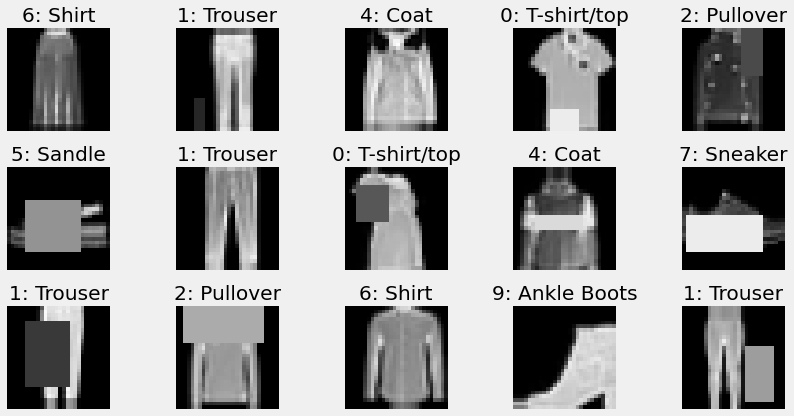

In [10]:
## source code: https://github.com/yu4u/mixup-generator/blob/master/random_eraser.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# prepare image data generator for augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=-1, v_h=1),
    validation_split=0.1,
)

# display images from
example_ds = train_datagen.flow(x=x_train, y=y_train)
fig = plt.figure()
for i in range(15):
    img, label = example_ds.next()
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow((img[0] + 1) / 2)
    ax.set_title(f"{label[0]}: {classes[label[0]]}")
    ax.axis('off')
plt.show()

In [11]:
# VGG16 Block
def vgg16_module(neurons: int, conv_num:int, num:int, dropout=0):
    '''
    Creates a generic Hidden Conv2D Layer with ReLU Activations
    Including Batch Normalization and Max Pooling Layers
    
    Args:
        - neurons: number of neurons in the dense layer
        - conv_num: number of conv layer
        - num    : block number
        - dropout: amount of dropout regularization to be applied
    '''
    block = Sequential(name=f'Covolution_Block_{num}')

    for i in range(conv_num):
      block.add(Conv2D(neurons, kernel_size=(3, 3),
                  activation='relu', strides=1, padding='same', kernel_initializer='he_normal'))
      block.add(BatchNormalization())

    block.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
    block.add(SpatialDropout2D(dropout, data_format='channels_last'))
    
    return block

In [12]:
def vgg16_builder(input_shape=(28, 28, 3)):
    model = Sequential(name='Custom_VGG16')
    
    # Input and Feature Engineering
    model.add(Input(input_shape, name='Input_Layer'))

    # Convolutional Block - Feature Extraction
    model.add(vgg16_module(64, 2, 0, 0))
    model.add(vgg16_module(128, 2, 1, 0))
    model.add(vgg16_module(256, 3, 2, 0))
    model.add(vgg16_module(512, 3, 3, 0))

    # Global Average Pooling - Global average pooling operation for spatial data
    model.add(GlobalAveragePooling2D(data_format='channels_last'))

    # Output Layer - Softmax Activation
    model.add(Dense(10, activation='softmax', name='Softmax_Output_Layer'))
    
    return model

In [13]:
# Initialise Weights and Biases run
current_time = datetime.datetime.now(sg).strftime("%d:%m:%Y_%H:%M")
run = wandb.init(
    project="Fashion MNIST ConvNet",
    name=f"Modified VGG16 {[current_time]}",
    config={
        "learning_rate": 0.001,
        "epochs": 100,
        "batch_size": 512,
        "loss_function": "sparse_categorical_crossentropy",
        "architecture": "Modified VGG16",
        "dataset": "Fashion MNIST"
    },
    group="Modified VGG16"
)

# Prepare Configurations
config = wandb.config

# Build the Network
tf.keras.backend.clear_session() # Resets all state generated by Keras
vgg = vgg16_builder()
vgg.summary()

# Preparing Optimizer
optimizer = Adam(learning_rate=config.learning_rate)

# Compiling - Adam Optimizer Categorical Cross Entropy Loss Function
vgg.compile(
    optimizer=optimizer, 
    loss=config.loss_function, 
    metrics=['accuracy']
)

Model: "Custom_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Covolution_Block_0 (Sequent  (None, 14, 14, 64)       39232     
 ial)                                                            
                                                                 
 Covolution_Block_1 (Sequent  (None, 7, 7, 128)        222464    
 ial)                                                            
                                                                 
 Covolution_Block_2 (Sequent  (None, 4, 4, 256)        1478400   
 ial)                                                            
                                                                 
 Covolution_Block_3 (Sequent  (None, 2, 2, 512)        5905920   
 ial)                                                            
                                                                 
 global_average_pooling2d (G  (None, 512)             

In [14]:
# Final Set of callback functions
callbacks = [
    WandbCallback(save_model=True),
    ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6, verbose=1),
]

In [15]:
%%time
# Train Model
baseline_hist = vgg.fit(
    x=train_datagen.flow(x_train, y_train, subset='training', batch_size=config.batch_size),
    validation_data=train_datagen.flow(x_train, y_train, subset='validation', batch_size=config.batch_size),
    epochs=config.epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=32,
    callbacks=callbacks
)
run.finish()

Epoch 1/100
94/94 [==============================] - 23s 184ms/step - loss: 0.8405 - accuracy: 0.7172 - val_loss: 1.1470 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 2/100
94/94 [==============================] - 17s 157ms/step - loss: 0.4649 - accuracy: 0.8240 - val_loss: 0.5967 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 3/100
94/94 [==============================] - 17s 158ms/step - loss: 0.3964 - accuracy: 0.8510 - val_loss: 0.4226 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 4/100
94/94 [==============================] - 16s 148ms/step - loss: 0.3572 - accuracy: 0.8642 - val_loss: 0.4921 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 5/100
94/94 [==============================] - 18s 163ms/step - loss: 0.3281 - accuracy: 0.8769 - val_loss: 0.4407 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 6/100
94/94 [==============================] - 17s 155ms/step - loss: 0.3048 - accuracy: 0.8845 - val_loss: 0.3460 - val_accuracy: 0.8724 - lr: 0.0010
Epoch 7/100
94/94 [==============================] - 17s 1

accuracy,▁▅▆▆▆▆▆▇▇▇▇▇▇▇██████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▇▆▇▇▇▇▇▇▇▇▇██████████████████████████
val_loss,█▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.97506
best_epoch,41
best_val_loss,0.17986
epoch,99
loss,0.06772
val_accuracy,0.93683


CPU times: user 9min 37s, sys: 10min 13s, total: 19min 51s
Wall time: 29min 6s


In [16]:
# in case of model training being interrupted
run.finish()

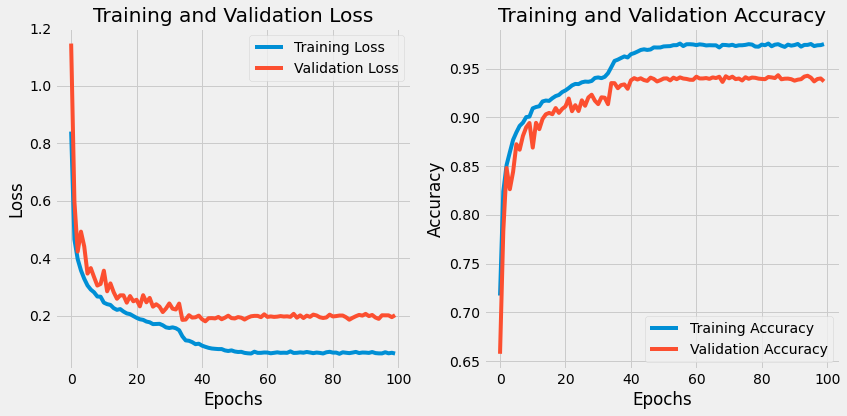

In [17]:
# Plot Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

ax1.plot(baseline_hist.history['loss'], label='Training Loss')
ax1.plot(baseline_hist.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
# ax1.set_ylim(bottom=0.0, top=1.0)
ax1.legend()

ax2.plot(baseline_hist.history['accuracy'], label='Training Accuracy')
ax2.plot(baseline_hist.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
# ax2.set_ylim(top=1.0, bottom=0.8)
ax2.legend()

plt.show()

In [18]:
# Evaluating Training and Testing Set
train = vgg.evaluate(x_train, y_train)
test  = vgg.evaluate(x_test, y_test)

# Creating a Logger to store all Evaluation Results
logger = pd.DataFrame(columns=['Train Loss', 'Train Acc', 'Test Loss', 'Test Acc'])
logger = logger.append(
    pd.Series(
        {
            'Train Loss': train[0],
            'Train Acc' : train[1],
            'Test Loss' : test[0],
            'Test Acc'  : test[1],
            'Test Percentage Error': "{:.2%}".format(1.0 - test[1])
        },
        name='Modified VGG16 w/ Image Augmentation',))
logger

313/313 [==============================] - 2s 6ms/step - loss: 0.2028 - accuracy: 0.9439


,Train Loss,Train Acc,Test Loss,Test Acc,Test Percentage Error
Modified VGG16 w/ Image Augmentation,0.066241,0.979117,0.202833,0.9439,5.61%


InvalidArgumentError: ignored

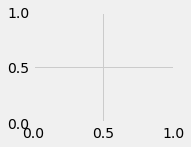

In [19]:
# Predict the values from the test dataset
y_pred = vgg.predict(x_test)
# Convert predictions classes to one hot encoded vectors 
y_pred_class = np.argmax(y_pred, axis = 1) 

w = 5
h = 3
fig = plt.figure(figsize=(12, 6), tight_layout=True)
for i in range(w*h):
  rand_idx = np.random.randint(0, len(x_test))
  ax = fig.add_subplot(h, w, i+1)
  ax.imshow((tf.reshape(x_test[rand_idx], (32, 32, 3))+1)/2)
  ax.axis('off')
  ax.set_title(f'Actual: {classes[y_test[rand_idx]]}\nPredicted: {classes[y_pred_class[rand_idx]]}', fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_class)

sns.heatmap(confusion_mtx, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='.3g')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# print out classification report
print(classification_report(y_test, y_pred_class, target_names=classes))

In [ ]:
# Display Model Architecture in Notebook Output
from tensorflow.keras.utils import plot_model
plot_model(vgg, show_shapes=True, show_dtype=True,
    show_layer_names=True, expand_nested=True, dpi=70)